<a href="https://colab.research.google.com/github/shreyasat27/MSc-QT-/blob/main/thesis_plts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 58.8 MB/s eta 0:00:00


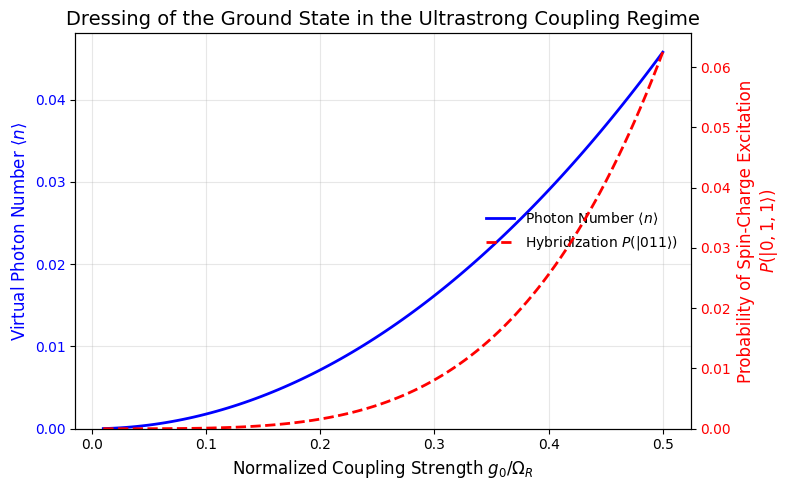

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the system parameters (from Fig 3.1 in the thesis)
Omega_R = 5.4  # GHz
E_plus = 18.0  # GHz
E_minus = 8.0  # GHz
phi_diff = np.pi / 4  # radians -> ga = g0*sin(pi/4), gb = g0*cos(pi/4)

# Define the small parameters delta (δ) and delta_prime (δ')
def calculate_delta(g0):
    ga = g0 * np.sin(phi_diff)
    return (2 * ga) / (E_minus - E_plus - 2 * Omega_R)

def calculate_delta_prime(g0):
    gb = g0 * np.cos(phi_diff)
    return (-2 * gb) / (E_minus + E_plus + 2 * Omega_R)

# Define the squeezing parameter r and coefficients c0, c2
# We use a simplified model for the squeezing parameter for the plot.
# A full calculation would use λ_3a and λ_3b, but the quadratic trend is key.
def calculate_squeezing(g0):
    # The squeezing parameter is proportional to g0^2.
    # We model it as r = -α * g0^2, capturing the leading order effect.
    alpha = 1 / (Omega_R * (E_plus + E_minus + 2 * Omega_R)) # Representative scale
    r = -alpha * (g0**2)
    c0 = 1 / np.sqrt(np.cosh(np.abs(r)))
    c2 = -np.tanh(np.abs(r)) / (np.sqrt(2) * np.cosh(np.abs(r)))
    return c0, c2

# Perturbative calculation of the expectation value for photon number <n>
def calculate_photon_number(g0):
    delta_val = calculate_delta(g0)
    delta_p_val = calculate_delta_prime(g0)
    c0, c2 = calculate_squeezing(g0)

    # <n> = <GS|a⁺a|GS>
    # The main contributions are:
    # 1. The |200> term (from squeezing V1): has 2 photons -> weight |c2|^2 * 2
    # 2. The |110> term: has 1 photon -> weight |c0 * δ|^2 * 1
    # 3. The |101> term: has 1 photon -> weight |c0 * δ'|^2 * 1
    # 4. The |211> term is higher order and we neglect it for this plot.
    n_expectation = (2 * np.abs(c2)**2) + (1 * np.abs(c0 * delta_val)**2) + (1 * np.abs(c0 * delta_p_val)**2)

    return n_expectation

# Perturbative calculation of the spin-charge hybridization
# We use a simplified measure: the probability to be in the |0,1,1> state
# (which is a spin-charge excited state) is a good indicator of hybridization.
def calculate_hybridization(g0):
    delta_val = calculate_delta(g0)
    delta_p_val = calculate_delta_prime(g0)
    c0, c2 = calculate_squeezing(g0)

    # The amplitude for |0,1,1> is approximately: a_011 = (c0/2)*δ*δ' - (c0/2)*φ_+(1/2)
    # Since φ_+(1/2) is also ~ g0^2, we model the whole term as proportional to g0^2.
    # The probability is |a_011|^2 ~ (g0^4). We use a simple quadratic model for visualization.
    p_011 = (g0 / Omega_R)**4 # Representative scaling

    return p_011

# Range of coupling strengths
g0_over_Omega = np.linspace(0.01, 0.5, 100)  # g0/Ω_R from 0.01 to 0.5
g0_values = g0_over_Omega * Omega_R

# Calculate the data
n_photons = []
hybridization = []
for g0 in g0_values:
    n_photons.append(calculate_photon_number(g0))
    hybridization.append(calculate_hybridization(g0))

# Create the plot
plt.figure(figsize=(8, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot Photon Number
ln1 = ax1.plot(g0_over_Omega, n_photons, 'b-', label='Photon Number $\\langle n \\rangle$', linewidth=2)
ax1.set_xlabel('Normalized Coupling Strength $g_0 / \\Omega_R$', fontsize=12)
ax1.set_ylabel('Virtual Photon Number $\\langle n \\rangle$', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylim(bottom=0) # Start at zero

# Plot Hybridization
ln2 = ax2.plot(g0_over_Omega, hybridization, 'r--', label='Hybridization $P(|011\\rangle)$', linewidth=2)
ax2.set_ylabel('Probability of Spin-Charge Excitation\n$P(|0,1,1\\rangle)$', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(bottom=0) # Start at zero

# Add a legend
lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right', frameon=False)

# Add title and grid
plt.title('Dressing of the Ground State in the Ultrastrong Coupling Regime', fontsize=14)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

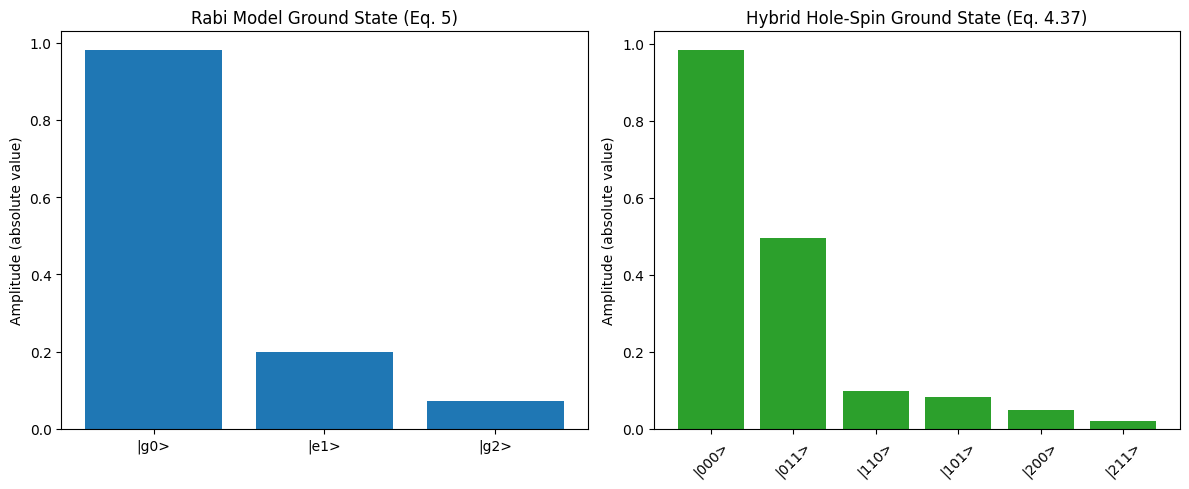

In [ ]:
# Install dependencies (matplotlib, numpy are usually pre-installed in Colab)
import numpy as np
import matplotlib.pyplot as plt


# 1. Define Rabi-model ground state (Eq. 5)


# Parameters for the perturbative USC expansion
Lambda = 0.2   # Bloch-Siegert mixing parameter (example value)
xi = 0.05      # squeezing parameter (example value)

# State labels and coefficients
rabi_states = ["|g0>", "|e1>", "|g2>"]
rabi_coeffs = [
    1 - Lambda**2/2,   # vacuum correction
    -Lambda,           # single excitation
    xi * np.sqrt(2)    # two-photon admixture
]

# 2. Define hybrid system ground state (Eq. 4.37 approx)


# Example parameters (choose small to mimic perturbative regime)
c0 = 1.0
c2 = 0.05
delta = 0.1
delta_p = 0.08

# State labels in your notation
hybrid_states = ["|000>", "|011>", "|110>", "|101>", "|200>", "|211>"]

# Approximate coefficients, simplified from Eq. 4.37
hybrid_coeffs = [
    c0 - c0*(delta**2 + delta_p**2),                  # vacuum
    -(c0 * 0.5 - c0*delta*delta_p/2),                 # |011>
    -(c0*delta - c2*0.5*delta_p/np.sqrt(2)),          # |110>
    +(c0*delta_p + c2*0.5*delta/np.sqrt(2)),          # |101>
    c2,                                               # |200>
    -(c2*0.5 - c0*delta*delta_p/np.sqrt(2))           # |211>
]

# 3. Plotting


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Rabi model amplitudes
axes[0].bar(rabi_states, np.abs(rabi_coeffs), color="tab:blue")
axes[0].set_title("Rabi Model Ground State (Eq. 5)")
axes[0].set_ylabel("Amplitude (absolute value)")

# Plot Hybrid system amplitudes
axes[1].bar(hybrid_states, np.abs(hybrid_coeffs), color="tab:green")
axes[1].set_title("Hybrid Hole-Spin Ground State (Eq. 4.37)")
axes[1].set_ylabel("Amplitude (absolute value)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


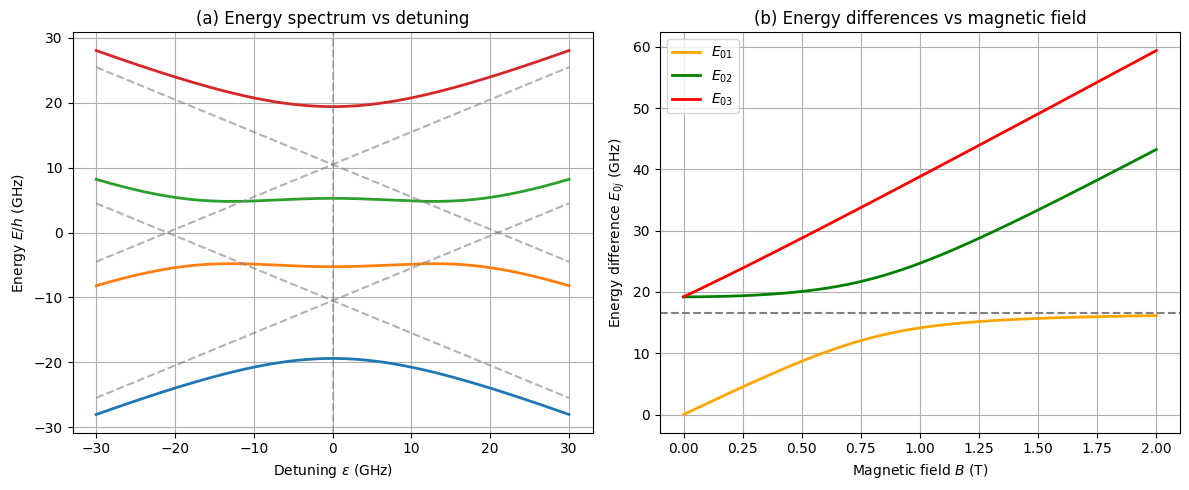

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# ---------------- Parameters ----------------
t_total = 9.6        # Total tunnel coupling (GHz)
theta = np.pi / 6    # Angle for splitting t_sc and t_sf (30°)
t_sc = t_total * np.cos(theta)  # Spin-conserving
t_sf = t_total * np.sin(theta)  # Spin-flipping

# Physical constants
muB_GHz_T = 13.99624555   # μB in GHz/T
g_factor = 1.5            # Example g-factor

def H_dqd(eps, t_sc, t_sf, B):
    """Double quantum dot Hamiltonian in basis |L↓>, |L↑>, |R↓>, |R↑>"""
    Ez = g_factor * muB_GHz_T * B   # Zeeman splitting in GHz
    H = np.array([
        [-eps/2 - Ez/2,     0,         -t_sc,      t_sf],
        [     0,      -eps/2 + Ez/2,   -t_sf,      -t_sc],
        [ -t_sc,       -t_sf,      eps/2 - Ez/2,     0  ],
        [ t_sf,       -t_sc,          0,       eps/2 + Ez/2]
    ])
    return Qobj(H)

# --------- Panel (a): Energies vs detuning ----------
eps_range = np.linspace(-30, 30, 300)  # GHz
B_fixed = 1.0   # Tesla
energies, energies_ref = [], []

for eps in eps_range:
    H = H_dqd(eps, t_sc, t_sf, B_fixed)
    energies.append(np.sort(H.eigenenergies()))

    H_ref = H_dqd(eps, 0, 0, B_fixed)
    energies_ref.append(np.sort(H_ref.eigenenergies()))

energies = np.array(energies)
energies_ref = np.array(energies_ref)

# --------- Panel (b): Energy differences vs B ----------
B_range = np.linspace(0, 2, 200)  # Tesla
E_diffs = []

for B_val in B_range:
    H = H_dqd(0, t_sc, t_sf, B_val)  # detuning = 0
    eigs = np.sort(H.eigenenergies())
    E_diffs.append([eigs[1]-eigs[0], eigs[2]-eigs[0], eigs[3]-eigs[0]])

E_diffs = np.array(E_diffs)

# --------- Plotting ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# (a) Energies vs detuning
for i in range(4):
    axes[0].plot(eps_range, energies[:, i], lw=2, label=f"Level {i}")
    axes[0].plot(eps_range, energies_ref[:, i], "--", color="gray", alpha=0.6)

axes[0].axvline(0, linestyle="--", color="gray", alpha=0.5)
axes[0].set_xlabel("Detuning $\\varepsilon$ (GHz)")
axes[0].set_ylabel("Energy $E/h$ (GHz)")
axes[0].set_title("(a) Energy spectrum vs detuning")
axes[0].grid(True)

# (b) Energy differences vs B
axes[1].plot(B_range, E_diffs[:,0], color="orange", lw=2, label="$E_{01}$")
axes[1].plot(B_range, E_diffs[:,1], color="green", lw=2, label="$E_{02}$")
axes[1].plot(B_range, E_diffs[:,2], color="red", lw=2, label="$E_{03}$")

axes[1].axhline(2*t_sc, ls="--", color="gray")  # reference line
axes[1].set_xlabel("Magnetic field $B$ (T)")
axes[1].set_ylabel("Energy difference $E_{0j}$ (GHz)")
axes[1].set_title("(b) Energy differences vs magnetic field")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/qutip/solver/solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


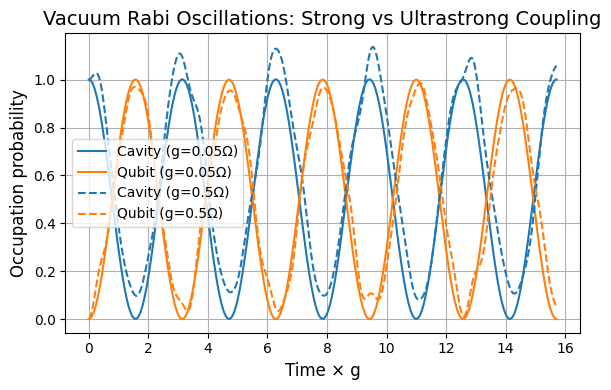

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# System constants
omega = 2 * np.pi
N = 4
theta = 0
epsilon = 2 * omega * np.sin(theta)
t_c = 1 * omega * np.cos(theta)

# Operators
a = tensor(destroy(N), qeye(2))
adag = a.dag()
sigma_x = tensor(qeye(N), Qobj([[0, 1], [1, 0]]))
sigma_z = tensor(qeye(N), Qobj([[1, 0], [0, -1]]))
idn = tensor(qeye(N), Qobj([[1, 0], [0, 1]]))

# Initial state: 1 photon in cavity, qubit in ground state
psi0 = tensor(basis(N, 1), basis(2, 0))

def simulate_dynamics(g):
    """Simulate the dynamics for a given coupling strength g."""
    tlist = np.linspace(0, 5*np.pi/g, 1000)
    H_interaction = (g * (a + adag)) * (np.sin(theta) * sigma_z + np.cos(theta) * sigma_x)
    omega_R = 2 * np.sqrt(((epsilon/2)**2) + t_c**2)
    H_res = omega_R * adag * a
    H_matrix = -np.sqrt(((epsilon/2)**2) + t_c**2) * sigma_z
    H = H_matrix + H_interaction + H_res
    c_ops = []  # no dissipation for this plot
    result = mesolve(H, psi0, tlist, c_ops, [adag * a, ((-sigma_z + idn) / 2)])
    return tlist * g, result.expect[0], result.expect[1]

# Simulate both cases
tlist_05g, cavity_05g, qubit_05g = simulate_dynamics(0.05 * omega)
tlist_5g,  cavity_5g,  qubit_5g  = simulate_dynamics(0.5  * omega)

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
# g = 0.05 omega (strong coupling, solid lines)
ax.plot(tlist_05g, cavity_05g, label="Cavity (g=0.05Ω)", color='tab:blue', linestyle='-')
ax.plot(tlist_05g, qubit_05g, label="Qubit (g=0.05Ω)", color='tab:orange', linestyle='-')
# g = 0.5 omega (ultrastrong coupling, dashed lines)
ax.plot(tlist_5g, cavity_5g, label="Cavity (g=0.5Ω)", color='tab:blue', linestyle='--')
ax.plot(tlist_5g, qubit_5g, label="Qubit (g=0.5Ω)", color='tab:orange', linestyle='--')

ax.set_xlabel("Time × g", fontsize=12)
ax.set_ylabel("Occupation probability", fontsize=12)
ax.set_title("Vacuum Rabi Oscillations: Strong vs Ultrastrong Coupling", fontsize=14)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


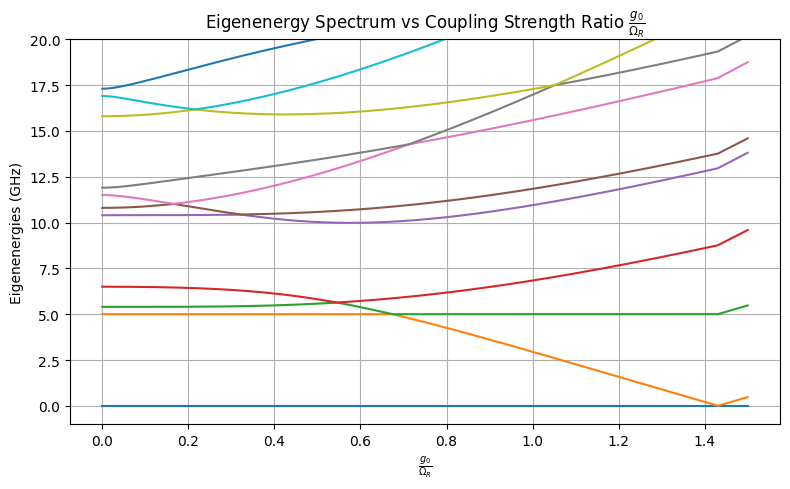

[-2.5  2.5  2.9  4.   7.9  8.3  9.   9.4 13.3 14.4 14.8 19.8]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# ----- Parameters -----
omega_R = 5.4 * 2 * np.pi    # GHz -> rad/s
E_plus = 18 * 2 * np.pi     # GHz
E_minus = 8 * 2 * np.pi   # GHz
tunnel_coupling = 9.6 * 2 * np.pi

phi = np.pi / 4               # 45 degrees for tunneling
theta = np.pi / 4             # 45 degrees for g_a/g_b

t_sc = tunnel_coupling * np.cos(phi)
t_sf = tunnel_coupling * np.sin(phi)

# Coupling scan
g0_vals = np.linspace(0, 1.5 * omega_R, 1000)   # GHz range converted to rad/s
g_angle = np.pi / 4                            # 45 degrees

# ----- System dimensions -----
Nph = 3             # photon cutoff
Ndot = 4            # 4-level system (|L↑>, |L↓>, |R↑>, |R↓>)

# Operators on dot+spin system
I4 = qeye(Ndot)
a = destroy(Nph)
adag = a.dag()
Iph = qeye(Nph)

# Define the system states in this order:
# |L↑>, |L↓>, |R↑>, |R↓>
# Define Pauli-like ops for spin (σ) and dot (τ)
# Custom matrices for 4-level space (manually construct):

# σ_z acts on spin up/down
sigma_z = Qobj(np.diag([1, -1, 1, -1]))
sigma_p = Qobj([[0, 1, 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 1],
                [0, 0, 0, 0]])
sigma_m = sigma_p.dag()

# τ_z acts on L/R
tau_z = Qobj([[1, 0, -1, 0],
              [0, 1, 0, -1],
              [-1, 0, 1, 0],
              [0, -1, 0, 1]]) / 2

tau_p = Qobj([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [0, 0, 0, 0],
              [0, 0, 0, 0]])
tau_m = tau_p.dag()

tau_x = tau_p + tau_m

# Tensor to total Hilbert space
def tensor_op(dot_op, ph_op):
    return tensor(dot_op, ph_op)

# Hamiltonian H_0
H0 = tensor_op(I4, omega_R * adag * a) \
     + tensor_op((E_plus + E_minus)/4 * tau_z, Iph) \
     + tensor_op((E_plus - E_minus)/4 * sigma_z, Iph)

# Storage for eigenenergies
eigenvals = []


# Sweep over g0
for g0 in g0_vals:
    g_a = g0 * np.cos(g_angle)
    g_b = g0 * np.sin(g_angle)

    # Interaction Hamiltonians
    H1 = g_a * (tensor_op(tau_z * sigma_p, a) + tensor_op(tau_z * sigma_m, adag)) \
       + g_b * (tensor_op(tau_p, a) + tensor_op(tau_m, adag))

    H2 = g_a * (tensor_op(tau_z * sigma_m, a) + tensor_op(tau_z * sigma_p, adag)) \
       + g_b * (tensor_op(tau_m, a) + tensor_op(tau_p, adag))

    H = H0 + H1 + H2

    evals = H.eigenenergies()
    eigenvals.append(evals[:16])

# Convert to numpy array for plotting
eigenvals = np.array(eigenvals)


# ----- Plotting -----
plt.figure(figsize=(8, 5))
for i in range(eigenvals.shape[1]):
    plt.plot(g0_vals / omega_R, eigenvals[:, i] / (2*np.pi)-eigenvals[:, 0] / (2*np.pi), label=f'Level {i+1}')


plt.title(r"Eigenenergy Spectrum vs Coupling Strength Ratio $\frac{g_0}{\Omega_R}$")
plt.xlabel(r'$\frac{g_0}{\Omega_R}$')
plt.ylabel('Eigenenergies (GHz)')
plt.ylim(-1,20)
plt.grid(True)
plt.tight_layout()
plt.show()
print(np.round(eigenvals[0] / (2*np.pi), 6))

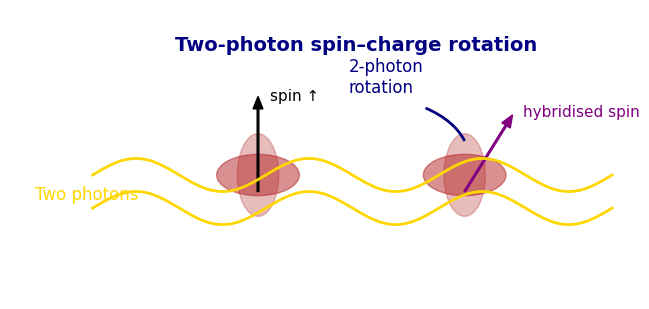

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Arc

fig, ax = plt.subplots(figsize=(8,6))

# --- Photons (two yellow wavy arrows) ---
x = np.linspace(0, 2*np.pi, 200)
for i in range(2):
    y = 0.2*np.sin(3*x) - i*0.4
    ax.plot(x-2.5, y, color="gold", lw=2)

# Photon labels
ax.text(-3.2, -0.3, "Two photons", fontsize=12, color="gold")

# --- Initial charge orbital (red dumbbell, left) ---
orb1 = Ellipse((-0.5,0), 1.0, 0.5, color="firebrick", alpha=0.5)
orb2 = Ellipse((-0.5,0), 0.5, 1.0, color="firebrick", alpha=0.3)
ax.add_patch(orb1)
ax.add_patch(orb2)

# Spin before (black up arrow)
ax.arrow(-0.5, -0.2, 0, 1, width=0.02, head_width=0.12, head_length=0.15, color="black")
ax.text(-0.35, 0.9, "spin ↑", fontsize=11, color="black")

# --- Final charge orbital (red dumbbell, right) ---
orb1f = Ellipse((2,0), 1.0, 0.5, color="firebrick", alpha=0.5)
orb2f = Ellipse((2,0), 0.5, 1.0, color="firebrick", alpha=0.3)
ax.add_patch(orb1f)
ax.add_patch(orb2f)

# Spin after (tilted arrow, hybridised)
ax.arrow(2, -0.2, 0.5, 0.8, width=0.02, head_width=0.12, head_length=0.15, color="purple")
ax.text(2.7, 0.7, "hybridised spin", fontsize=11, color="purple")

# --- Curved arrow showing transition ---
arc = Arc((0.8,0.2), 2.5, 1.5, theta1=10, theta2=40, color="navy", lw=2)
ax.add_patch(arc)
ax.text(0.6, 1.0, "2-photon\nrotation", fontsize=12, color="navy")

# --- Title ---
ax.text(-1.5, 1.5, "Two-photon spin–charge rotation", fontsize=14, weight="bold", color="navy")

# Aesthetics
ax.set_xlim(-3.5,4)
ax.set_ylim(-1.5,2)
ax.set_aspect("equal")
ax.axis("off")

plt.show()


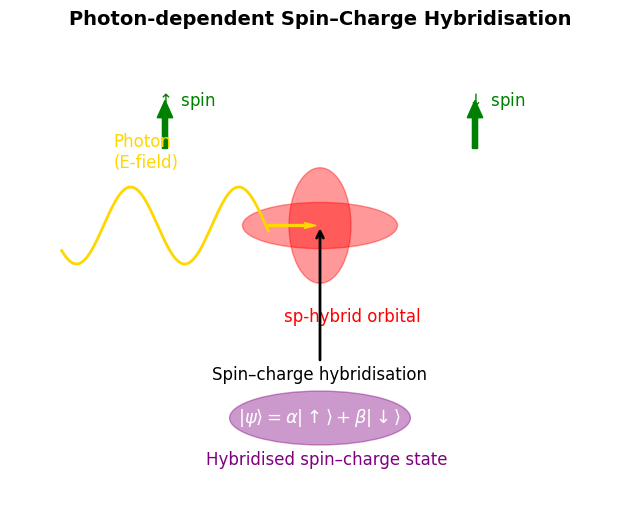

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, FancyArrow
import numpy as np

# Create figure
fig, ax = plt.subplots(figsize=(8,6))

# Spin representation (green arrows)
ax.add_patch(FancyArrow(-3, 2, 0, 0.8, width=0.1, color="green"))
ax.text(-3.2, 3.1, r"$\uparrow$ spin", fontsize=12, color="green")

ax.add_patch(FancyArrow(3, 2, 0, 0.8, width=0.1, color="green"))
ax.text(2.8, 3.1, r"$\downarrow$ spin", fontsize=12, color="green")

# sp hybrid orbital (center dumbbell-like orbit)
orb1 = Ellipse((0, 0), 3, 1.2, color="red", alpha=0.4)
orb2 = Ellipse((0, 0), 1.2, 3, color="red", alpha=0.4)
ax.add_patch(orb1)
ax.add_patch(orb2)
ax.text(-0.7, -2.5, "sp-hybrid orbital", fontsize=12, color="red")

# Photon wave (yellow sinusoidal arrow)
x_wave = np.linspace(-5, -1, 200)
y_wave = 1*np.sin(3*x_wave)
ax.plot(x_wave, y_wave, color="gold", linewidth=2)
ax.add_patch(FancyArrow(-1, 0, 0.7, 0, width=0.05, color="gold"))
ax.text(-4, 1.5, "Photon\n(E-field)", fontsize=12, color="gold")

# Hybridisation arrow (black curved)
ax.annotate("Spin–charge hybridisation",
            xy=(0, 0), xycoords="data",
            xytext=(0, -4), textcoords="data",
            arrowprops=dict(arrowstyle="->", color="black", lw=2),
            ha="center", fontsize=12)

# Hybridised state (bottom purple ellipse)
orb3 = Ellipse((0, -5), 3.5, 1.4, color="purple", alpha=0.4)
ax.add_patch(orb3)
ax.text(-2.2, -6.2, "Hybridised spin–charge state", fontsize=12, color="purple")

# Add spin superposition label inside ellipse
ax.text(0, -5, r"$|\psi\rangle = \alpha|\uparrow\rangle + \beta|\downarrow\rangle$",
        fontsize=13, color="white", ha="center", va="center", weight="bold")

# Style
ax.set_xlim(-6, 6)
ax.set_ylim(-7, 5)
ax.axis("off")
ax.set_title("Photon-dependent Spin–Charge Hybridisation", fontsize=14, weight="bold")

plt.show()


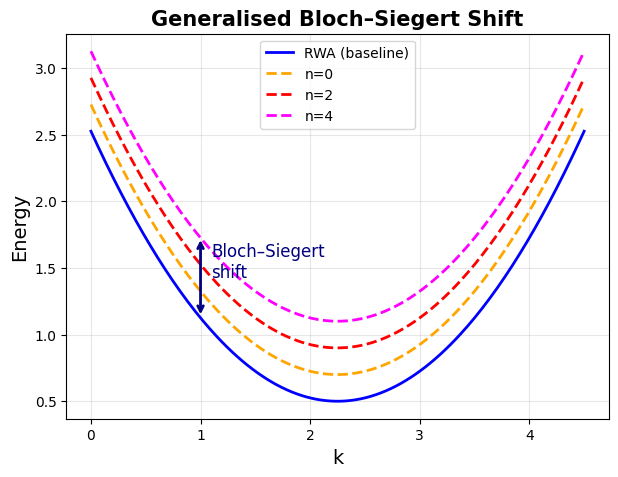

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define k-axis
k = np.linspace(0, 4.5, 200)

# Base parabola (RWA)
baseline = 0.5 + 0.4*(k-2.25)**2

# Shifted curves for n=0,2,4
shift_n0 = baseline + 0.2
shift_n2 = baseline + 0.4
shift_n4 = baseline + 0.6

plt.figure(figsize=(7,5))

# Plot baseline (blue solid)
plt.plot(k, baseline, color="blue", lw=2, label="RWA (baseline)")

# Plot shifted curves (dashed)
plt.plot(k, shift_n0, "--", color="orange", lw=2, label="n=0")
plt.plot(k, shift_n2, "--", color="red", lw=2, label="n=2")
plt.plot(k, shift_n4, "--", color="magenta", lw=2, label="n=4")

# Bloch-Siegert shift arrow
x0 = 1.0
y0 = baseline[np.argmin(np.abs(k-x0))]
plt.annotate(
    "", xy=(x0, y0+0.6), xytext=(x0, y0),
    arrowprops=dict(arrowstyle="<->", color="navy", lw=2)
)
plt.text(x0+0.1, y0+0.3, "Bloch–Siegert\nshift", color="navy", fontsize=12)

# Labels and legend
plt.xlabel("k", fontsize=14)
plt.ylabel("Energy", fontsize=14)
plt.title("Generalised Bloch–Siegert Shift", fontsize=15, weight="bold")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


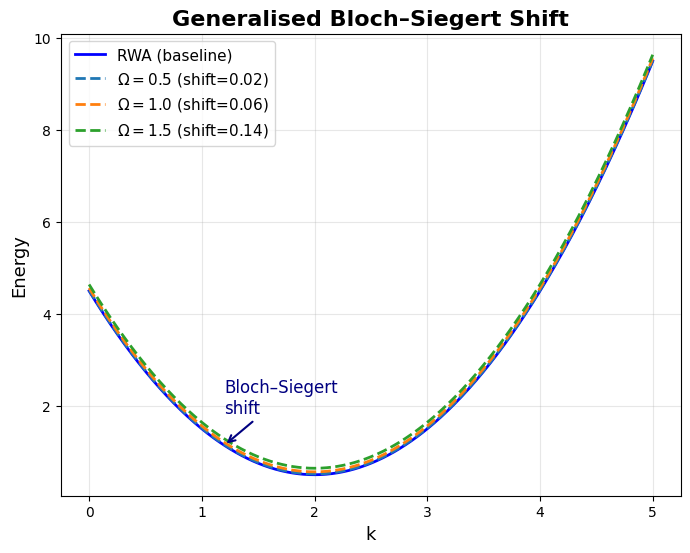

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
omega0 = 2.0          # Qubit frequency
omega_d = 2.0         # Drive frequency (near resonance)
Omega_vals = [0.5, 1.0, 1.5]  # Drive strengths (Rabi frequencies)

# Momentum-like variable
k = np.linspace(0, 5, 400)

# Baseline (RWA) parabola (schematic dispersion)
E_rwa = (k - 2)**2 + 0.5

plt.figure(figsize=(8,6))

# Plot RWA baseline
plt.plot(k, E_rwa, color="blue", lw=2, label="RWA (baseline)")

# Plot shifted dispersions with actual Bloch–Siegert correction
for Omega in Omega_vals:
    delta_bs = Omega**2 / (4*(omega0 + omega_d))
    E_shifted = E_rwa + delta_bs
    plt.plot(k, E_shifted, "--", lw=2,
             label=fr"$\Omega={Omega}$ (shift={delta_bs:.2f})")

# Annotate Bloch–Siegert shift
x0 = 1.2
y0 = (x0 - 2)**2 + 0.5
plt.annotate("Bloch–Siegert\nshift",
             xy=(x0, y0), xytext=(x0, y0+0.7),
             arrowprops=dict(arrowstyle="->", color="navy", lw=1.5),
             fontsize=12, color="navy")

# Aesthetics
plt.title("Generalised Bloch–Siegert Shift", fontsize=16, weight="bold")
plt.xlabel("k", fontsize=13)
plt.ylabel("Energy", fontsize=13)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.show()


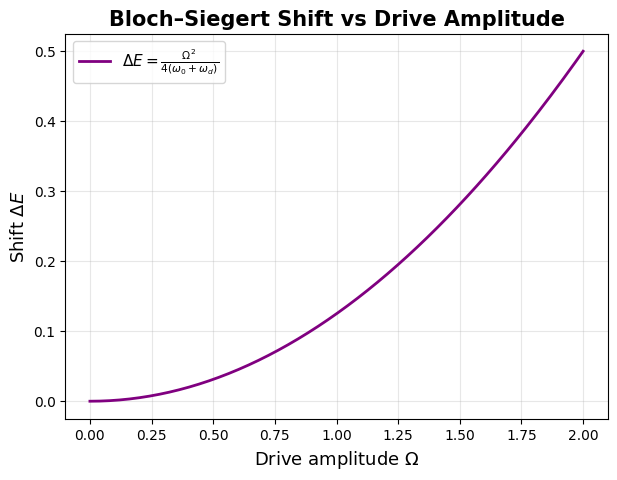

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
omega0 = 1.0      # qubit frequency
omega_d = 1.0     # drive frequency
Omega = np.linspace(0, 2, 200)  # drive amplitude range

# Bloch-Siegert shift
DeltaE = Omega**2 / (4 * (omega0 + omega_d))

# Plot
plt.figure(figsize=(7,5))
plt.plot(Omega, DeltaE, color="purple", lw=2, label=r"$\Delta E = \frac{\Omega^2}{4(\omega_0+\omega_d)}$")
plt.xlabel(r"Drive amplitude $\Omega$", fontsize=13)
plt.ylabel(r"Shift $\Delta E$", fontsize=13)
plt.title("Bloch–Siegert Shift vs Drive Amplitude", fontsize=15, weight="bold")
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.show()


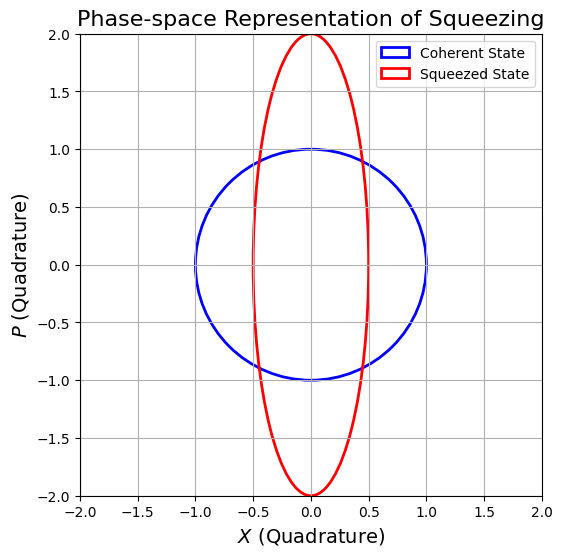

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

# Function to plot an uncertainty ellipse
def plot_uncertainty(ax, center, sigma_x, sigma_p, angle, color, label):
    ellipse = Ellipse(xy=center, width=2*sigma_x, height=2*sigma_p,
                      angle=np.degrees(angle), edgecolor=color, facecolor='none', lw=2, label=label)
    ax.add_patch(ellipse)

# Create figure
fig, ax = plt.subplots(figsize=(8,6))

# Original coherent state (circular uncertainty)
plot_uncertainty(ax, center=(0,0), sigma_x=1, sigma_p=1, angle=0, color='blue', label='Coherent State')

# Squeezed state (squeezing along X)
squeezing_factor = 0.5  # <1 means squeezed along X, stretched along P
plot_uncertainty(ax, center=(0,0), sigma_x=squeezing_factor, sigma_p=1/squeezing_factor,
                 angle=0, color='red', label='Squeezed State')

# Axes labels and settings
ax.set_xlabel(r'$X$ (Quadrature)', fontsize=14)
ax.set_ylabel(r'$P$ (Quadrature)', fontsize=14)
ax.set_title('Phase-space Representation of Squeezing', fontsize=16)
ax.set_aspect('equal', 'box')
ax.grid(True)
ax.legend()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

plt.show()


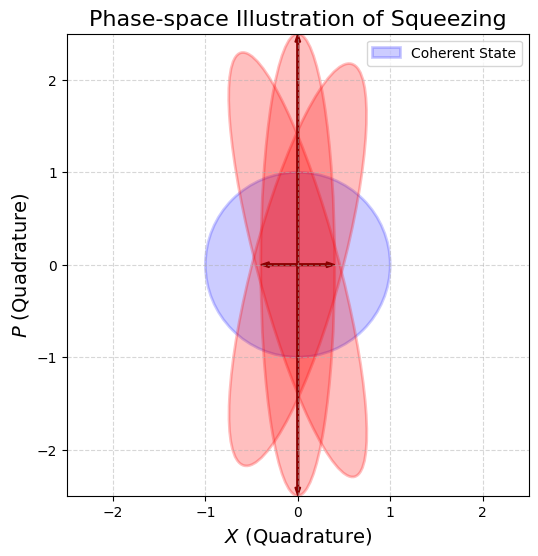

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, FancyArrow
import numpy as np

# Function to plot a squeezed ellipse with transparency
def plot_squeezing(ax, center, sigma_x, sigma_p, angle, color, alpha=0.3, label=None):
    ellipse = Ellipse(xy=center, width=2*sigma_x, height=2*sigma_p,
                      angle=np.degrees(angle), edgecolor=color, facecolor=color, alpha=alpha, lw=2, label=label)
    ax.add_patch(ellipse)

# Function to draw arrows along ellipse axes
def draw_axes(ax, center, sigma_x, sigma_p, angle, color):
    dx = sigma_x * np.cos(angle)
    dy = sigma_x * np.sin(angle)
    ax.add_patch(FancyArrow(center[0], center[1], dx, dy, width=0.02, color=color, length_includes_head=True))
    ax.add_patch(FancyArrow(center[0], center[1], -dx, -dy, width=0.02, color=color, length_includes_head=True))

    dx = sigma_p * -np.sin(angle)
    dy = sigma_p * np.cos(angle)
    ax.add_patch(FancyArrow(center[0], center[1], dx, dy, width=0.02, color=color, length_includes_head=True))
    ax.add_patch(FancyArrow(center[0], center[1], -dx, -dy, width=0.02, color=color, length_includes_head=True))

# Create figure
fig, ax = plt.subplots(figsize=(8,6))

# Coherent state ellipse
plot_squeezing(ax, center=(0,0), sigma_x=1, sigma_p=1, angle=0, color='blue', alpha=0.2, label='Coherent State')

# Multiple squeezed ellipses to show evolution
squeezing_factor = 0.4
angles = [0, np.pi/12, -np.pi/12]  # small rotations for aesthetics
for i, ang in enumerate(angles):
    plot_squeezing(ax, center=(0,0), sigma_x=squeezing_factor*(1+0.1*i), sigma_p=1/squeezing_factor*(1-0.05*i),
                   angle=ang, color='red', alpha=0.25)

# Draw axes arrows for the final squeezed state
draw_axes(ax, center=(0,0), sigma_x=squeezing_factor, sigma_p=1/squeezing_factor, angle=0, color='darkred')

# Axes settings
ax.set_xlabel(r'$X$ (Quadrature)', fontsize=14)
ax.set_ylabel(r'$P$ (Quadrature)', fontsize=14)
ax.set_title('Phase-space Illustration of Squeezing', fontsize=16)
ax.set_aspect('equal', 'box')
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)

plt.show()
